## Librerías a utilizar

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report


## Importar y almacenar datos

Código revisado: [link](https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset_spine.csv to dataset_spine.csv


In [ ]:
import io
data = pd.read_csv(io.BytesIO(uploaded['dataset_spine.csv']))

Hay 12 características que describen el dolor de espalda y dos clases: *abnormal* y *normal*. Más información del *dataset* [acá](https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset)

In [ ]:
data

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,0.129744,7.8433,14.7484,8.51707,-15.728927,11.5472,Normal,NaN
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,0.047913,19.1986,18.1972,7.08745,6.013843,43.8693,Normal,NaN
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,0.081070,16.2059,13.5565,8.89572,3.564463,18.4151,Normal,NaN
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,0.159251,14.7334,16.0928,9.75922,5.767308,33.7192,Normal,NaN


Los nombres de las clases se cambian:

In [ ]:
data['Class_att'] = data['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

data['Class_att'].replace(encode_map, inplace=True)

In [ ]:
data

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,1,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,1,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,1,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,1,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,0.129744,7.8433,14.7484,8.51707,-15.728927,11.5472,0,NaN
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,0.047913,19.1986,18.1972,7.08745,6.013843,43.8693,0,NaN
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,0.081070,16.2059,13.5565,8.89572,3.564463,18.4151,0,NaN
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,0.159251,14.7334,16.0928,9.75922,5.767308,33.7192,0,NaN


Se define `X` como las características e `y` como sus clases.

In [ ]:
X = data.iloc[:, 0:-2]
y = data.iloc[:, -2]

In [ ]:
X

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171
...,...,...,...,...,...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,0.129744,7.8433,14.7484,8.51707,-15.728927,11.5472
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,0.047913,19.1986,18.1972,7.08745,6.013843,43.8693
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,0.081070,16.2059,13.5565,8.89572,3.564463,18.4151
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,0.159251,14.7334,16.0928,9.75922,5.767308,33.7192


In [ ]:
y

0      1
1      1
2      1
3      1
4      1
      ..
305    0
306    0
307    0
308    0
309    0
Name: Class_att, Length: 310, dtype: int64

Con el método `train_test_split` de `sklearn` se divide el dataset en *train* y *test*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=77)
# Notar que es 0.9*0.2 = 0.18 del original
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=77)

Se normalizan los datos siguiendo: 
$z = \frac{x - u}{s}$
con $u$ como el promedio y $s$ la desviación estándar. 
Se utiliza el método `StandardScaler` de `sklearn` más información [acá](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train

array([[-0.34068279,  0.2504743 , -0.97483496, ...,  0.87711325,
         1.51415731,  1.74886913],
       [-1.44410479, -1.31717761, -0.56573336, ...,  1.0638498 ,
         0.99035374, -0.41309296],
       [-1.7527233 , -1.03113173, -1.47485019, ...,  0.00200761,
        -1.02581233, -1.28188895],
       ...,
       [-0.84079981, -0.26654167, -0.76896533, ..., -1.07597081,
         1.47818432, -0.86885901],
       [ 0.1185221 ,  0.95113892, -0.06875039, ..., -1.5482922 ,
         1.66411082, -1.20299303],
       [-0.72534507,  0.00435635, -0.04842162, ..., -1.22783117,
        -0.70581524,  1.38723148]])

In [ ]:
X_train.shape

(223, 12)

In [ ]:
y_train.shape

(223,)

## Pytorch

In [ ]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import Sequential, Linear, LazyLinear
from torch.nn import ELU, ReLU, Tanh, Sigmoid, Softmax

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
EPOCHS = 15 #cuantas veces entrenas 
BATCH_SIZE = 32 #tamaño del batch
LEARNING_RATE = 0.001

Creamos una Clase SimpleDataset para controlar la carga de datos.

In [ ]:
class SimpleDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]
        
    def __len__ (self):
        return len(self.X_data)

train_data = SimpleDataset(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

  
test_data = SimpleDataset(torch.FloatTensor(X_test), 
                       torch.FloatTensor(y_test.to_numpy()))

val_data = SimpleDataset(torch.FloatTensor(X_val.to_numpy()), 
                       torch.FloatTensor(y_val.to_numpy()))

Con el data loader normalizamos los datos de la clase al Batch. Recordar que el metodo correrá a una cantidad  EPOCHS de epocas dividiendo la matriz X_train en segmentos o batches de tamaño BATCH_SIZE files.

In [ ]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

Aqui definimos la estrucutra vacia de la Red Neuronal.

Linear(tamaño(entrada),tamaño(salida))) corresponde al Layer 

ReLU() es la función de activación





In [ ]:
arch_small = OrderedDict([('input', Linear(X_train.shape[1], 64)),
                         ('relu1', ReLU()),
                         ('hidden', Linear(64, 28)),
                         ('relu2', ReLU()),
                         ('output', Linear(28, 2))])
mlp = Sequential(arch_small)

Esto corresponde a la función de solo una epoca.

In [ ]:
def epoch(model, optimizer, lossfn, loader, istrain=True):
    epoch_loss = 0
    epoch_acc = 0

    if istrain:
        model.train() #para entrenar el modelo
    else:
        model.eval() #es para evaluar y predecir el modelo.

    for (input, labels) in loader:
        input, labels = input.to(device), labels.to(device) #manda datos a tu dispositivo

        prediction = model(input)#Se calcula una prediccion en el tensor de salida
                                 #da una probabilidad de peternencia para cada una de las clases (AQUI SON 2, [0,1])
        predicted_label = prediction.argmax(dim=1, keepdim=True)  #escoje una clase con respecto a la probabilidad más alta

        optimizer.zero_grad() #El optimizador establece su gradiente inicia en cero
        loss =  criterion(prediction, labels.long()) #Se calcula la perdida 
        acc = binary_acc(predicted_label.squeeze(), labels.squeeze())

        if istrain:
            loss.backward() # se inizializa el back propagation en el modelo.
            optimizer.step()#Se calculan los gradientes y se aplica un paso de actualizacion de pesos
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    mean_loss =  epoch_loss / len(loader)
    mean_acc = epoch_acc / len(loader)

    return mean_loss, mean_acc

def binary_acc(y_pred, y_test):
    correct_results_sum = (y_pred == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc


**La** perdida `CrossEntropyLoss` actúa sobre la última capa y agruega una combinación de una capa `LogSoftmax` con pérdida `NLLLoss`, más información [acá](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).  La razón para esto, es que el resultado final de la red entregará un valor determinado. La función `LogSoftmax` convierte este valor en una probablidad para que así la función `NLLLoss` clasifique el resultado y calcule la perdida.

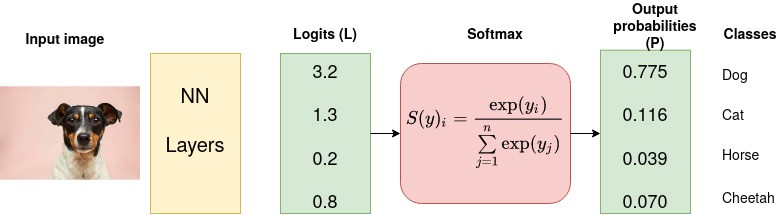


In [ ]:
mlp.to(device)
print(mlp)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=LEARNING_RATE)

Sequential(
  (input): Linear(in_features=12, out_features=64, bias=True)
  (relu1): ReLU()
  (hidden): Linear(in_features=64, out_features=28, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=28, out_features=2, bias=True)
)


In [ ]:
import time
import datetime
import sys

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []


for ep in range(EPOCHS):
    loss_train, acc_train = epoch(mlp, optimizer, criterion, train_loader, istrain=True)
    train_loss_history.append(loss_train)
    train_acc_history.append(acc_train)
    print(f'Epoch Train {ep+0:02}: | Loss: {loss_train:.5f} | Acc: {acc_train:.3f}')

    # Acá se revisar el rendimiento del set de validación



Epoch Train 00: | Loss: 0.69036 | Acc: 53.429
Epoch Train 01: | Loss: 0.64518 | Acc: 67.857
Epoch Train 02: | Loss: 0.60855 | Acc: 67.714
Epoch Train 03: | Loss: 0.57653 | Acc: 67.714
Epoch Train 04: | Loss: 0.54315 | Acc: 67.857
Epoch Train 05: | Loss: 0.51852 | Acc: 67.571
Epoch Train 06: | Loss: 0.49323 | Acc: 67.714
Epoch Train 07: | Loss: 0.47015 | Acc: 71.286
Epoch Train 08: | Loss: 0.44843 | Acc: 77.000
Epoch Train 09: | Loss: 0.43073 | Acc: 82.286
Epoch Train 10: | Loss: 0.41184 | Acc: 83.571
Epoch Train 11: | Loss: 0.39387 | Acc: 85.714
Epoch Train 12: | Loss: 0.37572 | Acc: 85.571
Epoch Train 13: | Loss: 0.35987 | Acc: 86.143
Epoch Train 14: | Loss: 0.34406 | Acc: 86.000


In [ ]:
history = {'acc': train_acc_history,
           'loss': train_loss_history,
           'val_acc': val_acc_history,
           'val_loss': val_loss_history,
           'epoch': list(range(EPOCHS))}

In [ ]:
import matplotlib.pyplot as plt
def plot_history(hist, abslim=100, sqrtlim=3):

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'],
            label='Train')
    plt.ylim([0,abslim])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train')
    plt.ylim([0,sqrtlim])
    plt.legend()
    plt.show()

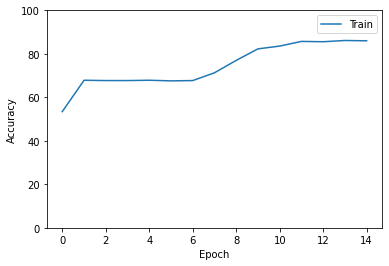

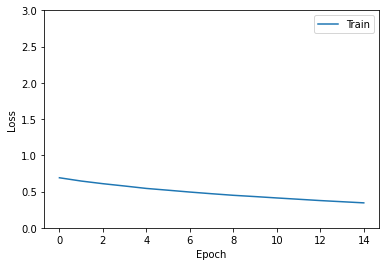

In [ ]:
plot_history(history)

In [ ]:
y_pred_list = []
y_label_list = []
mlp.eval()
with torch.no_grad():
    for (input, label) in test_loader:
        input = input.to(device)
        y_test_pred = mlp(input)
        y_test_pred= y_test_pred.argmax(dim=1, keepdim=True)
        y_pred_list.append(y_test_pred.numpy())
        y_label_list.append(label.tolist())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

y_pred = []
for elements in y_pred_list:
  for e in elements:
    y_pred.append(e)

In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 5,  3],
       [ 6, 17]])

la diagonal de 0,0 + 1,1 esta bien clasificada mientras que la diagonal 0,1 + 1,0 esta mal clasificada

## Keras

In [ ]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=77)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Lo que hace el to_categorical es definir la clase de cada resultado

en Keras 

Si es clase 0 —> [1, 0]

Si es clase 1 —> [0, 1]

Mientras que en Pytorch (debido a la función de perdida que nosotros utilizamos)

0 —> 0

1 —> 1



In [ ]:
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

Aqui definimos la estrucutra de la Red Neuronal

In [ ]:
mlp = Sequential() #Definición del modelo
mlp.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
mlp.add(Dense(28, activation='relu'))
mlp.add(Dense(2, activation='softmax'))
mlp.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_16 (Dense)             (None, 28)                1820      
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 58        
Total params: 2,710
Trainable params: 2,710
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Generación del grafo de cómputo
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

#Entrenamiento y recuperación de datos de entrenamiento
history = mlp.fit(X_train, y_train_cat, epochs=15, batch_size=32, verbose=1)


Epoch 1/15
9/9 [==============================] - 1s 2ms/step - loss: 0.7191 - accuracy: 0.4447
Epoch 2/15
9/9 [==============================] - 0s 1ms/step - loss: 0.6086 - accuracy: 0.6944
Epoch 3/15
9/9 [==============================] - 0s 2ms/step - loss: 0.5435 - accuracy: 0.6910
Epoch 4/15
9/9 [==============================] - 0s 2ms/step - loss: 0.5039 - accuracy: 0.7084
Epoch 5/15
9/9 [==============================] - 0s 1ms/step - loss: 0.4839 - accuracy: 0.7523
Epoch 6/15
9/9 [==============================] - 0s 1ms/step - loss: 0.4453 - accuracy: 0.7558
Epoch 7/15
9/9 [==============================] - 0s 2ms/step - loss: 0.4322 - accuracy: 0.8063
Epoch 8/15
9/9 [==============================] - 0s 1ms/step - loss: 0.3981 - accuracy: 0.8396
Epoch 9/15
9/9 [==============================] - 0s 2ms/step - loss: 0.3954 - accuracy: 0.8418
Epoch 10/15
9/9 [==============================] - 0s 1ms/step - loss: 0.3996 - accuracy: 0.8435
Epoch 11/15
9/9 [======================

Para acceder a los resultados usan el *output* de *fit*

In [ ]:
print(history.history)

{'loss': [0.6952784657478333, 0.5978052616119385, 0.5418955087661743, 0.5026123523712158, 0.47130489349365234, 0.4465710520744324, 0.4252866208553314, 0.4057927429676056, 0.38937488198280334, 0.3728060722351074, 0.3578430712223053, 0.34352871775627136, 0.33009928464889526, 0.3174627125263214, 0.3055773973464966], 'accuracy': [0.5089605450630188, 0.6881720423698425, 0.6953405141830444, 0.7096773982048035, 0.7383512258529663, 0.7706093192100525, 0.8028674125671387, 0.8243727684020996, 0.8530465960502625, 0.8673835396766663, 0.8781362175941467, 0.8709677457809448, 0.8817204236984253, 0.8781362175941467, 0.8924731016159058]}


In [ ]:
history.history['epoch'] = list(range(EPOCHS))


In [ ]:
#@title

import matplotlib.pyplot as plt
def plot_history(hist, abslim=1.2, sqrtlim=0.5):

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
            label='Train')
    plt.ylim([0,abslim])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train')
    plt.ylim([0,sqrtlim])
    plt.legend()
    plt.show()

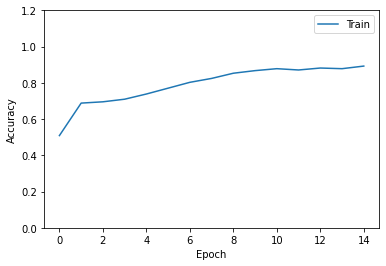

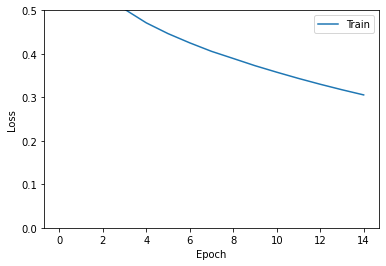

In [ ]:
plot_history(history.history)

In [ ]:
test_predictions = mlp.predict(X_test)

https://machinelearningmastery.com/5-step-life-cycle-neural-network-models-keras/

In [ ]:
print(y_test.values)
print(np.argmax(test_predictions,axis=1))

[1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0]
[0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1 0]


In [ ]:
confusion_matrix(y_test, np.argmax(test_predictions,axis=1))

array([[ 6,  2],
       [ 7, 16]])